In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
AUTOTUNE = tf.data.experimental.AUTOTUNE 

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_size = [64,64]
batch_size = 64
epoch = 100

In [4]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/train/',
#     labels='inferred',
#     label_mode='categorical',
    validation_split=0.2,
    subset="training",
    color_mode='grayscale',
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [5]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/train',
#         labels='inferred',
#     label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    color_mode='grayscale',
    seed=123,
    image_size=(64,64),
    batch_size=batch_size,
)

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [6]:
val_data.class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [7]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_data.class_names = class_names
val_data.class_names = class_names

NUM_CLASSES = len(class_names)

In [8]:
train_data.class_names[labels[i]]

NameError: name 'labels' is not defined

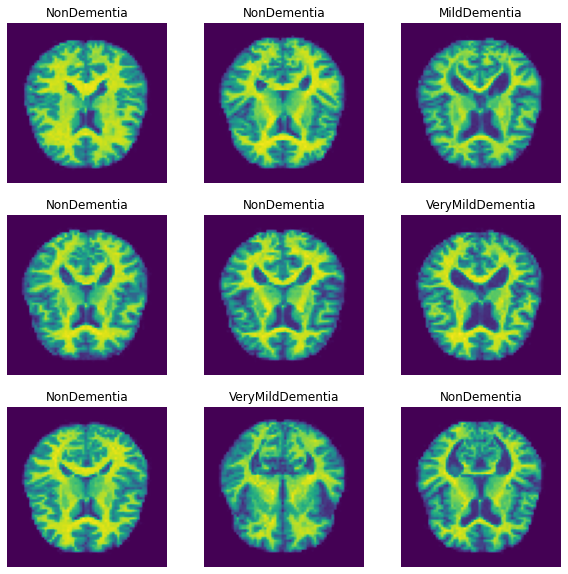

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[labels[i]])
    plt.axis("off")

In [10]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_data = train_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [11]:
for images, labels in train_data:
    print(labels)

tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]], shape=(64, 4), dtype=float3

tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]], shape=(64, 4), dtype=float3

tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]], shape=(64, 4), dtype=float3

tf.Tensor(
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]], shape=(64, 4), dtype=float3

tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]], shape=(64, 4), dtype=float3

tf.Tensor(
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]], shape=(64, 4), dtype=float3

In [12]:
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
#         tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.Input(shape=(*image_size, 1)),
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model

In [14]:
model = build_model()

METRICS = [
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [52]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.15 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 20)

checkpoint_filepath = 'src/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)


In [53]:
history = model.fit(
    train_data,
    validation_data=val_data,
    callbacks=[early_stopping_cb, lr_scheduler, model_checkpoint_callback],
    epochs=epoch)

Epoch 1/100
65/65 [==============================] - 16s 241ms/step - loss: 0.7226 - AUC: 0.9034 - precision: 0.7241 - recall: 0.5643 - val_loss: 3.1177 - val_AUC: 0.4819 - val_precision: 0.1479 - val_recall: 0.1396
Epoch 2/100
65/65 [==============================] - 16s 241ms/step - loss: 0.6727 - AUC: 0.9169 - precision: 0.7254 - recall: 0.6383 - val_loss: 2.4329 - val_AUC: 0.7757 - val_precision: 0.5391 - val_recall: 0.5322
Epoch 3/100
65/65 [==============================] - 16s 243ms/step - loss: 0.5737 - AUC: 0.9399 - precision: 0.7689 - recall: 0.7325 - val_loss: 1.1024 - val_AUC: 0.8785 - val_precision: 0.6799 - val_recall: 0.6533
Epoch 4/100
65/65 [==============================] - 16s 246ms/step - loss: 0.4962 - AUC: 0.9550 - precision: 0.8000 - recall: 0.7801 - val_loss: 4.5640 - val_AUC: 0.7002 - val_precision: 0.5173 - val_recall: 0.5107
Epoch 5/100
65/65 [==============================] - 16s 245ms/step - loss: 0.4697 - AUC: 0.9595 - precision: 0.8161 - recall: 0.7972 - 

65/65 [==============================] - 16s 246ms/step - loss: 0.0592 - AUC: 0.9993 - precision: 0.9866 - recall: 0.9856 - val_loss: 0.4085 - val_AUC: 0.9708 - val_precision: 0.9013 - val_recall: 0.9004
Epoch 23/100
65/65 [==============================] - 16s 249ms/step - loss: 0.0542 - AUC: 0.9993 - precision: 0.9880 - recall: 0.9873 - val_loss: 0.4641 - val_AUC: 0.9665 - val_precision: 0.8837 - val_recall: 0.8828
Epoch 24/100
65/65 [==============================] - 16s 245ms/step - loss: 0.0529 - AUC: 0.9996 - precision: 0.9878 - recall: 0.9866 - val_loss: 0.3676 - val_AUC: 0.9746 - val_precision: 0.9068 - val_recall: 0.9023
Epoch 25/100
65/65 [==============================] - 16s 242ms/step - loss: 0.0501 - AUC: 0.9996 - precision: 0.9892 - recall: 0.9878 - val_loss: 0.6275 - val_AUC: 0.9526 - val_precision: 0.8560 - val_recall: 0.8535


In [36]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [37]:
!pip install pydot

/usr/bin/sh: 1: pip: not found


In [38]:
!brew install graphviz

/usr/bin/sh: 1: brew: not found


In [39]:
#data augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)



In [54]:

datagen = ImageDataGenerator(validation_split=0.2, 
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False)
train_generator = datagen.flow_from_directory(
        'Alz_data/train',
        target_size=(64,64),
        batch_size=100,
        color_mode='grayscale',
#         class_mode='categorical',
        subset='training')
validation_generator = datagen.flow_from_directory(
        'Alz_data/train',
        target_size=(64,64),
        color_mode='grayscale',
        batch_size=100,
#         class_mode='categorical',
        subset='validation')

test_generator = datagen.flow_from_directory(
        'Alz_data/test',
        target_size=(64,64),
        color_mode='grayscale',
        batch_size=100)
#         class_mode='categorical',


Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [55]:
img_hist = model.fit(
        train_generator,
        validation_data=validation_generator,
        callbacks=[early_stopping_cb, lr_scheduler, model_checkpoint_callback], 
        epochs=epoch)

Epoch 1/100
41/41 [==============================] - 12s 292ms/step - loss: 1.1488 - AUC: 0.8313 - precision: 0.6138 - recall: 0.5010 - val_loss: 2.4027 - val_AUC: 0.7398 - val_precision: 0.5000 - val_recall: 0.4995
Epoch 2/100
41/41 [==============================] - 12s 289ms/step - loss: 0.8637 - AUC: 0.8577 - precision: 0.6784 - recall: 0.4046 - val_loss: 5.1305 - val_AUC: 0.3641 - val_precision: 0.1398 - val_recall: 0.1398
Epoch 3/100
41/41 [==============================] - 12s 289ms/step - loss: 0.8233 - AUC: 0.8702 - precision: 0.6857 - recall: 0.4505 - val_loss: 2.7916 - val_AUC: 0.4611 - val_precision: 0.1560 - val_recall: 0.1388
Epoch 4/100
41/41 [==============================] - 12s 293ms/step - loss: 0.7953 - AUC: 0.8817 - precision: 0.7083 - recall: 0.4746 - val_loss: 1.8092 - val_AUC: 0.7950 - val_precision: 0.5227 - val_recall: 0.4946
Epoch 5/100
41/41 [==============================] - 12s 294ms/step - loss: 0.7834 - AUC: 0.8846 - precision: 0.6896 - recall: 0.5237 - 

In [56]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/test/',
#             labels='inferred',
#     label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,
)

Found 1279 files belonging to 4 classes.


In [57]:
test_data = test_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [21]:
test_data

<ParallelMapDataset shapes: ((None, 64, 64, 1), (None, 4)), types: (tf.float32, tf.float32)>

In [58]:
score_data = model.evaluate(test_data)

20/20 [==============================] - 1s 29ms/step - loss: 1.1318 - AUC: 0.8348 - precision: 0.5813 - recall: 0.5285


In [23]:
for images, labels in test_data:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

In [24]:
numpy_images.shape

(63, 64, 64, 1)

In [ ]:
numpy_labels.shape

In [45]:
y_true = np.array([x[1].numpy() for x in list(test_data)])


In [25]:
class_names = [ 'NonDementia', 'VeryMildDementia', 'MildDementia', 'ModerateDementia']
train_data.class_names = class_names
val_data.class_names = class_names
test_data.class_names = class_names

NUM_CLASSES = len(class_names)

In [26]:
y_true.shape

NameError: name 'y_true' is not defined

In [59]:
score = model.evaluate(test_generator)

13/13 [==============================] - 1s 65ms/step - loss: 1.1145 - AUC: 0.8312 - precision: 0.5464 - recall: 0.5160


In [28]:
predictions =model.predict(test_data, steps=len(test_data))
# con_mat = tf.math.confuy_pred=model.predict_classes(test_data)sion_matrix(labels=y_true, predictions=y_pred).numpy()

In [29]:
y_pred.shape

NameError: name 'y_pred' is not defined

In [30]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=-1))

In [31]:
y_true = test_generator.classes

In [32]:
y_true

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [33]:
cm

array([[  4,   0,  91,  84],
       [  0,   0,   6,   6],
       [ 12,   0, 318, 310],
       [ 10,   0, 204, 234]])

In [35]:
# for image, label in test_generator:
#     print(label)

In [ ]:
for idx, predict in enumerate(predictions):
    print(idx, predict)
#     for true in y_true:
#         if predict[i] != true[i]:
#             print(idx, predict)

In [36]:
# for idx, labels in test_generator:
#     print(labels)

In [109]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.savefig('model_confusion_matrix.png')

In [110]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=-1))

In [111]:
import itertools

Normalized confusion matrix
[[0.02234637 0.         0.50837989 0.46927374]
 [0.         0.         0.5        0.5       ]
 [0.01875    0.         0.496875   0.484375  ]
 [0.02232143 0.         0.45535714 0.52232143]]


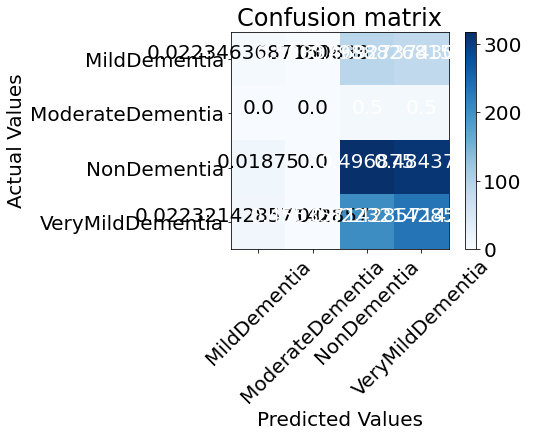

In [112]:
cm_plot_labels = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, normalize=True)

In [ ]:
 plot_confusion_matrix(classifier, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=normalize)

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [120]:
cm_plot_labels = ['Mild', 'Moderate', 'None', 'Very Mild']

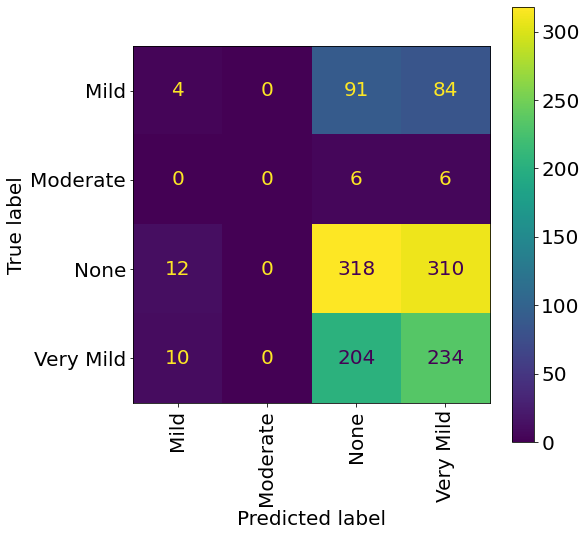

In [121]:
predictions = model.predict(test_generator)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
fig, ax=plt.subplots(figsize=(8,8))
disp.plot(xticks_rotation=90, ax=ax)

In [72]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
y_true=test_generator.classes
y_pred=np.argmax(predictions, axis=-1)

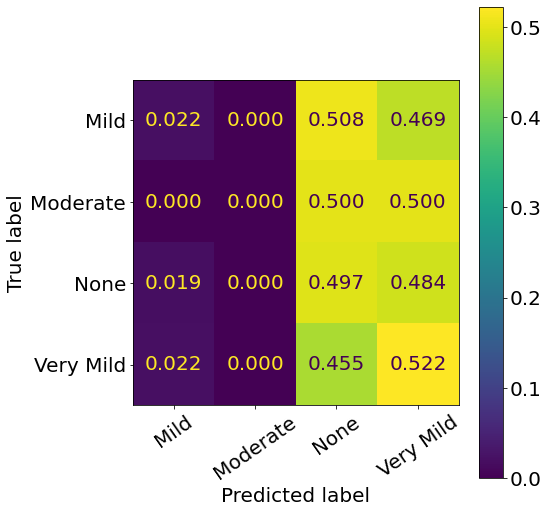

In [125]:
# plt.rcParams.update({'font.size': 20})
cm = confusion_matrix(y_true, y_pred, labels=None, normalize='true', color)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
fig, ax=plt.subplots(figsize=(8,8))
disp.plot(xticks_rotation=35, ax=ax, values_format='.3f')
fig.tight_layout()
fig.savefig('model_confusion_matrix.png')